# Food Reviews Sentiment Analysis & Recommendation System
### By: Eric Tran
## Introduction
I will be attempting to improve upon the Amazon Fine Food Reviews SA and recommendation system given as an example in class, with different settings and methods. We will be using the 'Amazon Fine Food Review' from Kaggle at <br><br>https://www.kaggle.com/datasets/snap/amazon-fine-food-reviews<br><br>
Using the reviews, we will use a RNN with LSTM to perform Sentiment Analysis on the reviews. We will then use a Restricted Boltzmann Machine (RBM) using tensorflow v1 to make a recommendation system.
<br><br>
Let's start by loading the libraries and dataset.

In [ ]:
# Utilities
import pandas as pd
import datetime
import re

# Visualization
from matplotlib import pyplot as plt
import numpy as np
import seaborn as sns

# ML DL
import keras
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dense, LSTM, Embedding, Dropout
from tensorflow.keras.models import Sequential

# NLP stopwords
from keras.preprocessing.text import Tokenizer
from nltk.corpus import stopwords
from string import punctuation

In [2]:
# turn warnings off
import warnings
warnings.filterwarnings("ignore")

In [4]:
# Import the data set
df = pd.read_csv('datasets/Reviews.csv')
df.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 568454 entries, 0 to 568453
Data columns (total 10 columns):
 #   Column                  Non-Null Count   Dtype 
---  ------                  --------------   ----- 
 0   Id                      568454 non-null  int64 
 1   ProductId               568454 non-null  object
 2   UserId                  568454 non-null  object
 3   ProfileName             568438 non-null  object
 4   HelpfulnessNumerator    568454 non-null  int64 
 5   HelpfulnessDenominator  568454 non-null  int64 
 6   Score                   568454 non-null  int64 
 7   Time                    568454 non-null  int64 
 8   Summary                 568427 non-null  object
 9   Text                    568454 non-null  object
dtypes: int64(5), object(5)
memory usage: 43.4+ MB


It looks like there are over half a million reviews, but our processing power will not make this feasible, so I will be taking the first 24k reviews in honor of Kobe Bryant.

In [7]:
df = df[0:24000] # only using the first 24,000 reviews

Now we will grab only the columns we need. We will take ProductId so we know the product, ProfileName so we know the reviewer, Score so we know what they scored, Summary for displaying at end, Text for the actual review for SA and recommendation, and the two Helpfulness columns to rate helpfulness.

In [8]:
# save needed columns in new df
df_reviews = df[['ProductId','ProfileName','Score','Summary','Text','HelpfulnessNumerator','HelpfulnessDenominator']]

Now let's get familiar with our most active reviewers.

In [9]:
# Display the top 10 Reviewers by most reviews.
df.pivot_table(columns=['ProfileName'], aggfunc='size').sort_values(ascending=False).head(10)

ProfileName
c2                                            24
Chris                                         19
C. F. Hill "CFH"                              17
Carrie, "Formerly &#34;Sister Carrie&#34;"    17
Gary Peterson                                 17
John                                          15
Dan                                           15
Sharon                                        12
Bill                                          12
O. Brown "Ms. O. Khannah-Brown"               12
dtype: int64

It looks like c2 is our most active reviewer with 24 reviews, followed by Chris with 19, and then the others.
<br><br>
Let's explore our top reviewer, c2, a little more in depth.

In [13]:
#Filtering all the reviews made by user c2
c2_reviews = df_reviews[df_reviews['ProfileName']=='c2']
c2_reviews

,ProductId,ProfileName,Score,Summary,Text,HelpfulnessNumerator,HelpfulnessDenominator
143,B001GVISJW,c2,5,Great for the kids!,If you are looking for a less messy version of...,0,0
3587,B004X8TK9W,c2,5,AWESOME!,I may be dating myself here a bit but I rememb...,1,1
4993,B000FA398U,c2,5,Best for oyster soup!,Try these first for all your seafood soups and...,3,3
6371,B000084EKO,c2,3,Not any different than regular Friskies,I honestly cannot say that I saw any differenc...,0,0
6372,B000084EKA,c2,4,Not their best...,I think 9 Lives does a better job on this vari...,0,0
6373,B000084EKB,c2,4,Great food!,This version is ground. NOt my current cat's ...,0,0
6374,B000084EKC,c2,5,Great food for all cats!,"According to my cat, this stuff is just great....",1,1
6375,B000084EKD,c2,2,Needs improved,I haven't had a cat yet that liked this one. ...,1,1
6380,B000084EKG,c2,5,Awesome food!,This is my cat's favorite one. He just licks ...,2,2
6382,B000084EK8,c2,3,Not the favorite in our house,Once or twice a year for a little variety and ...,2,2


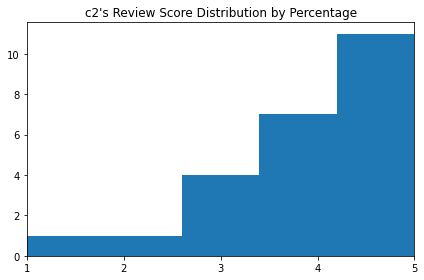

In [14]:
fig, axs = plt.subplots(sharey=True, tight_layout=True)
axs.hist(c2_reviews['Score'],bins=5)
plt.xlim([1, 5])
plt.xticks(np.arange(1, 6, 1))
plt.title("c2's Review Score Distribution by Percentage")
plt.show()

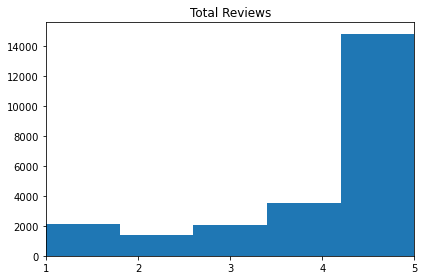

In [15]:
fig, axs = plt.subplots(sharey=True, tight_layout=True)
axs.hist(df_reviews['Score'],bins=5)
plt.xlim([1, 5])
plt.xticks(np.arange(1, 6, 1))
plt.title('Total Reviews')
plt.show()

As we can see, there is a bit more of a curve to c2's distribution compared to all the reviews. We can also see c2's reviews has Helpfulness scores, indicating other users found c2's reviews helpful. Good job c2, you're a model reviewer!
<br><br>Now let's check out the top 10 products with the most reviews.

In [10]:
# Display the top 10 products by most reviews.
df.pivot_table(columns=['ProductId'], aggfunc='size').sort_values(ascending=False).head(10)

ProductId
B002QWP89S    632
B000KV61FC    556
B003VXFK44    455
B006N3IG4K    455
B001LG945O    347
B001LGGH40    341
B004ZIER34    330
B005K4Q1VI    324
B0013NUGDE    312
B008ZRKZSM    310
dtype: int64

Text(0, 0.5, 'Number of users review')

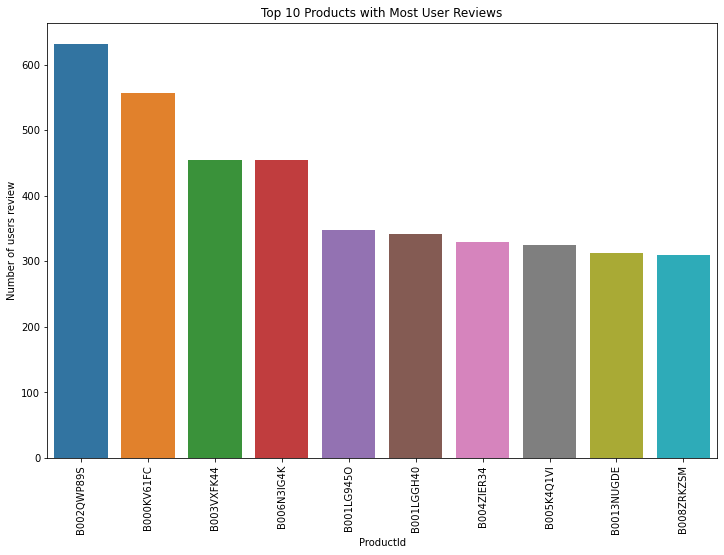

In [11]:
top = df[['ProductId', 'ProfileName']].groupby('ProductId').agg({'ProfileName':'count'}) # create aggregated df with count of users review for each productId
p = top.sort_values('ProfileName', ascending = False).head(10) # sort the values based of number of users count
plt.figure(figsize = (12,8)) # set size of figure to display
sns.barplot(x = p.index, y = p.ProfileName, order=p.index) # display barplot using index as the order and the count as y
plt.xticks(rotation = 90) # rotate ProductId for easier viewing
plt.title('Top 10 Products with Most User Reviews')
plt.ylabel('Number of users review')

We can see the distribution and number of reviews for the top 10 products, but unfortunately this dataset does not contain the name of the product, only the productID number, so we can only guess what all the rave is about.
<br><br>
Next, we are going to create a new column with the polarity, where if the score scores of 4 or 5 is positive, 3 is neutral, and less than 3 is negative.

In [24]:
df_reviews['Polarity_Rating'] = df_reviews['Score'].apply(lambda x: 'Positive' if x > 3 else x)
df_reviews['Polarity_Rating'] = df_reviews['Polarity_Rating'].apply(lambda x: 'Neutral' if isinstance(x, int) and x ==3 else x)
df_reviews['Polarity_Rating'] = df_reviews['Polarity_Rating'].apply(lambda x: 'Negative' if isinstance(x, int) and x < 3 else x)

<AxesSubplot:xlabel='Polarity_Rating', ylabel='count'>

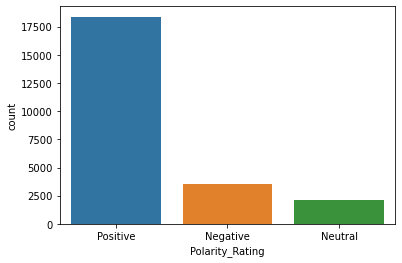

In [25]:
sns.countplot(data = df_reviews, x= 'Polarity_Rating')

In [29]:
df_reviews[df_reviews['Polarity_Rating'] == 'Positive'].shape[0]

18375

In [26]:
df_reviews[df_reviews['Polarity_Rating'] == 'Negative'].shape[0]

3542

In [27]:
df_reviews[df_reviews['Polarity_Rating'] == 'Neutral'].shape[0]

2083

It looks like there are a lot more positive reviews, so we are going to make a balanced df where the number of positive and negative reviews match, but we will keep the neutral the same slightly lower than the others, since neutral represents only the score 3 where as positive and negative each represent 2 scores.

In [31]:
data_Positive = df_reviews[df_reviews['Polarity_Rating'] == 'Positive'][0:3542]
data_Negative = df_reviews[df_reviews['Polarity_Rating'] == 'Negative']
data_Neutral = df_reviews[df_reviews['Polarity_Rating'] == 'Neutral']

data_Negative_over = data_Negative.sample(8000, replace=True)
df_balance_reviews = pd.concat([data_Positive, data_Neutral, data_Negative_over], axis=0)

### Data Cleaning
We will clean the data. We will set the actual reviews as x_data, and the polarity rating as the y_data. We then clean the x_data, taking out html tags, anything not a letter, stopwords, and making everything lower case.
<br><br>
We will also replace Positive with 1, and both Negative and Neutral with 0, in the y_data. Even though this skews our data more towards negative, this is done because sigmoid output is more efficient and is best with 1 neuron, where output is logistic. Otherwise we could try tanh function with 3 output neurons, but that would be more tuning hyperparameters.

In [32]:
# Setting the stop words
english_stops = set(stopwords.words('english'))

In [69]:
df = df_balance_reviews # copy df
x_data = df['Text']       # Reviews/Input as x_data
y_data = df['Polarity_Rating']    # Sentiment/Output as y_data

# PRE-PROCESS REVIEW
x_data = x_data.replace({'<.*?>': ''}, regex = True)          # remove html tag
x_data = x_data.replace({'[^A-Za-z]': ' '}, regex = True)     # remove non alphabet
x_data = x_data.apply(lambda review: [w for w in review.split() if w not in english_stops])  # remove stop words
x_data = x_data.apply(lambda review: [w.lower() for w in review])   # lower case

# ENCODE SENTIMENT -> 0 & 1
y_data = y_data.replace('Positive', 1)
y_data = y_data.replace('Neutral', 0)
y_data = y_data.replace('Negative', 0)

### LSTM RNN
Let's continue preparing the data for a RNN with LSTM (Long-Short-Term Memory). We will split the data into train and test sets, and make a function to get the maximum length of the reviews, for padding later.

In [70]:
# split data into train test, 20% test size, random_state=42
X_train, X_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.2, random_state=42)

In [71]:
# function to get max length of reviews for padding
def get_max_length(x_train):
    review_length = []
    for review in x_train:
        review_length.append(len(review))

    return int(np.ceil(np.mean(review_length)))

In [72]:
max_length = get_max_length(X_train)
print(max_length)

49


Now that we have the max length of the reviews, we will encode it by tokenizing the reviews, then turning it into a sequence before padding the sequence to the max length.

In [73]:
# ENCODE REVIEW
token = Tokenizer(lower=False)    # False becuase we already did it. 
token.fit_on_texts(X_train) # tokenize X_train
x_train = token.texts_to_sequences(X_train) # encode to sequence
x_test = token.texts_to_sequences(X_test) # encode x_test to sequence

### add the pad to x_train
x_train = pad_sequences(x_train, maxlen=max_length, padding='post', truncating='post')

### add pad to x_test  
x_test = pad_sequences(x_test, maxlen=max_length, padding='post', truncating='post')

total_words = len(token.word_index) + 1   # we need to add 1 because of 0 padding

#### RNN with LSTM
It's time to build the RNN with LSTM. We start with the embed dimensions, where each dimension can learn a feature. We will use 3200 because it is a high number that should get any features we have.<br><br>
Next we instantiate a sequential model, and add embedding layer before the LSTM layer. We then add a 20% dropout layer to help against overfitting, before having a Dense output layer with 1 neuron with sigmoid activation, so it will be either a score between 0 and 1, for negative to positive. We then compile with adam optimizer and binary_crossentropy as the loss function.
<br><br>We will also create a checkpoint to save progress on completed epochs.

In [74]:
# RNN LSTM ARCHITECTURE
EMBED_DIM = 3200
LSTM_OUT = 64

# Instantiate a sequential model
model = Sequential()

#model.add(Embedding(input_dim=max_length, output_dim=LSTM_OUT,input_length=max_length))
model.add(Embedding(total_words, EMBED_DIM, input_length = max_length))
model.add(LSTM(LSTM_OUT)) # LSTM layer
model.add(Dropout(0.2)) # dropout to help against overfitting
model.add(Dense(units=1, activation='sigmoid'))

### compile the model using: optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy']
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

#Adding a Checkpoint to save the model.
checkpoint = ModelCheckpoint('models/LSTM.h5', monitor='accuracy', save_best_only=True, verbose=1)

In [75]:
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_6 (Embedding)     (None, 49, 3200)          55430400  
                                                                 
 lstm_6 (LSTM)               (None, 64)                835840    
                                                                 
 dense_6 (Dense)             (None, 1)                 65        
                                                                 
Total params: 56266305 (214.64 MB)
Trainable params: 56266305 (214.64 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Time to fit the model. We will use 8 epochs in other of Kobe's other retired jersey.

In [76]:
history = model.fit(x_train, y_train, epochs=8, batch_size=20, callbacks= [checkpoint],validation_data=(x_test, y_test))

Epoch 1/8
545/545 [==============================] - ETA: 0s - loss: 0.4557 - accuracy: 0.7951
Epoch 1: accuracy improved from -inf to 0.79514, saving model to models\LSTM.h5
545/545 [==============================] - 367s 671ms/step - loss: 0.4557 - accuracy: 0.7951 - val_loss: 0.2882 - val_accuracy: 0.8855
Epoch 2/8
545/545 [==============================] - ETA: 0s - loss: 0.1829 - accuracy: 0.9311
Epoch 2: accuracy improved from 0.79514 to 0.93110, saving model to models\LSTM.h5
545/545 [==============================] - 380s 698ms/step - loss: 0.1829 - accuracy: 0.9311 - val_loss: 0.2565 - val_accuracy: 0.9090
Epoch 3/8
545/545 [==============================] - ETA: 0s - loss: 0.0571 - accuracy: 0.9821
Epoch 3: accuracy improved from 0.93110 to 0.98211, saving model to models\LSTM.h5
545/545 [==============================] - 367s 674ms/step - loss: 0.0571 - accuracy: 0.9821 - val_loss: 0.2948 - val_accuracy: 0.9057
Epoch 4/8
545/545 [==============================] - ETA: 0s - l

Now let's plot the loss and accuracy to analyze how the model did.

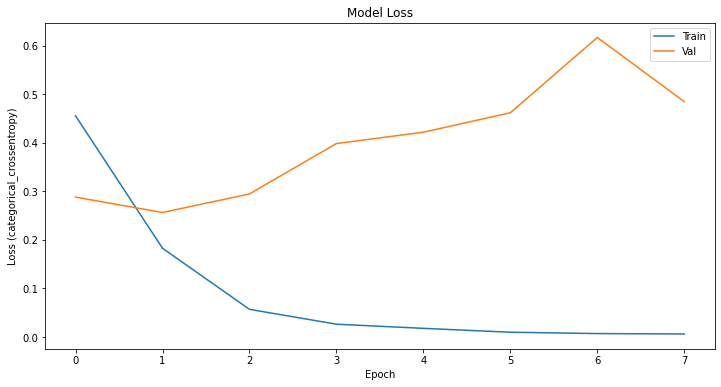

In [77]:
plt.figure(figsize=(12,6))
plt.plot(model.history.history['loss'][:])
plt.plot(model.history.history['val_loss'][:])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss (categorical_crossentropy)')
plt.legend(['Train', 'Val'], loc='upper right')

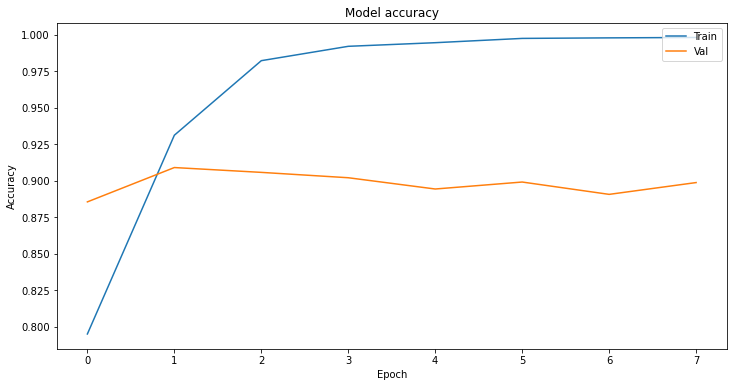

In [78]:
plt.figure(figsize=(12,6))
plt.plot(model.history.history['accuracy'][:])
plt.plot(model.history.history['val_accuracy'][:])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper right')
plt.show()

It looks like although the accuracy was surprisingly high, the loss on test set was going up before barely starting to drop again. We may have been in a local minima before breaking out. I really should of went with Kobe's 24 jersey for epochs instead of 8, but I was afraid of the process time.
<br><br>


### Predicting Sentiment
Now let's have some fun. We will grab a random review, clean the review, encode it, then make a prediction based on the model we fit. Let's pick index 2020, for the year Kobe died, so not completely random, but random in the context of the data.

In [79]:
#I grab a random review from the dataframe
value = 2020
df_reviews.iloc[value]

ProductId                                                        B001E5E29A
ProfileName                                                      FPU "Dave"
Score                                                                     5
Summary                                                Farmhouse Waffle Mix
Text                      Makes very good, light waffles. Seems to be ex...
HelpfulnessNumerator                                                      1
HelpfulnessDenominator                                                    1
Polarity_Rating                                                    Positive
Name: 2020, dtype: object

In [80]:
review = df_reviews.iloc[value]['Text']
print(review)

"Makes very good, light waffles. Seems to be exactly the same as Carbon's Golden Malted waffle mix. Only this is more expensive."

In [81]:
# clean data
regex = re.compile(r'[^a-zA-Z\s]') # make patern for letters only
review = regex.sub('', review) # replace non letters with no space

words = review.split(' ') # split words into list
filtered = [w for w in words if w not in english_stops] # take out stopwords
filtered = ' '.join(filtered) # join list
filtered = [filtered.lower()] # lower case

In [82]:
tokenize_words = token.texts_to_sequences(filtered) # tokenize words to sequences
tokenize_words = pad_sequences(tokenize_words, maxlen=max_length, padding='post', truncating='post') # pad sequences

In [83]:
result = model.predict(tokenize_words)

if result >= .50:
    print('Postive')
else:
    print('Negative')

1/1 [==============================] - 2s 2s/step
Postive


That worked great. Reading the review, it sounded mostly positive besides the comment on the price, but had a score of 5 so it was definitely positive.

Let's make a function that will take in a number, and print the corresponding summary and review, along with prediction whether it is positive or negative.

In [86]:
def predict_sentiment(value):
    review = df_reviews.iloc[value]['Text']
    summary = df_reviews.iloc[value]['Summary']
    score = df_reviews.iloc[value]['Score']
    regex = re.compile(r'[^a-zA-Z\s]')
    review = regex.sub('', review)

    words = review.split(' ')
    filtered = [w for w in words if w not in english_stops]
    filtered = ' '.join(filtered)
    filtered = [filtered.lower()]
    tokenize_words = token.texts_to_sequences(filtered)
    tokenize_words = pad_sequences(tokenize_words, maxlen=max_length, padding='post', truncating='post')
    result = model.predict(tokenize_words)
    print(f'Review Index: {value}')
    print(f'Review Summary: {summary}')
    print(f'Review Text: {review}')
    if result >= .50:
        print('Prediction of Sentiment is: Postive')
        print(f'Sentiment Score Prediction: {result}')
        print(f'Actual Review Score: {score}')
        
    else:
        print('Prediction of Sentiment is: Negative')
        print(f'Sentiment Score Prediction: {result}')
        print(f'Actual Review Score: {score}')

In [87]:
predict_sentiment(2023)

1/1 [==============================] - 0s 32ms/step
Review Index: 2023
Review Summary: Excellent choice for Belgian Waffles
Review Text: I have a Waring belgian waffle maker and was looking for a good batter to use I tried this based on reviews and with add my strong recommendation for this mixbr br It was very easy to make and the waffles had a wonderful flavor  loved the malt flavor that came throughbr br I will definitely be buying more when the current mix runs out
Prediction of Sentiment is: Postive
Sentiment Score Prediction: [[0.99933594]]
Actual Review Score: 5


The function seems to work good.
### RBM
Now let's prep the data for the RBM. We will start by giving each user or ProfileName a unique UserID using pandas.factorize()
<br><br>After that, we will find the UserID of our top reviewer, c2.

In [88]:
#Making an Unique Numeric ID for all the users
df_reviews['UserID'] = pd.factorize(df_reviews['ProfileName'])[0] + 1

In [89]:
df_reviews[df_reviews['ProfileName'] == 'c2'].head()

,ProductId,ProfileName,Score,Summary,Text,HelpfulnessNumerator,HelpfulnessDenominator,Polarity_Rating,UserID
143,B001GVISJW,c2,5,Great for the kids!,If you are looking for a less messy version of...,0,0,Positive,143
3587,B004X8TK9W,c2,5,AWESOME!,I may be dating myself here a bit but I rememb...,1,1,Positive,143
4993,B000FA398U,c2,5,Best for oyster soup!,Try these first for all your seafood soups and...,3,3,Positive,143
6371,B000084EKO,c2,3,Not any different than regular Friskies,I honestly cannot say that I saw any differenc...,0,0,Neutral,143
6372,B000084EKA,c2,4,Not their best...,I think 9 Lives does a better job on this vari...,0,0,Positive,143


c2 has been given UserID 143, 'I love you'.

In [90]:
df_reviews[df_reviews['UserID'] == 143].head()

,ProductId,ProfileName,Score,Summary,Text,HelpfulnessNumerator,HelpfulnessDenominator,Polarity_Rating,UserID
143,B001GVISJW,c2,5,Great for the kids!,If you are looking for a less messy version of...,0,0,Positive,143
3587,B004X8TK9W,c2,5,AWESOME!,I may be dating myself here a bit but I rememb...,1,1,Positive,143
4993,B000FA398U,c2,5,Best for oyster soup!,Try these first for all your seafood soups and...,3,3,Positive,143
6371,B000084EKO,c2,3,Not any different than regular Friskies,I honestly cannot say that I saw any differenc...,0,0,Neutral,143
6372,B000084EKA,c2,4,Not their best...,I think 9 Lives does a better job on this vari...,0,0,Positive,143


#### Further cleaning
We will clean data one more time to drop multiple reviews of product from the same user. We will drop duplicates and only keep the last follow up review rather than all the reviews.

In [92]:
# clean the data some more, some reviewers went back to review the same item mulitple times as a follow up.
cleaned = df_reviews.drop_duplicates(subset=['ProductId', 'UserID'], keep='last')

print('Total Reviews: {}'.format(df_reviews.shape[0]))
print('Removed Dulipcated, Total Reviews Left: {}'.format(cleaned.shape[0]))


Total Reviews: 24000
Removed Dulipcated, Total Reviews Left: 23641


In [93]:
cleaned.head()

,ProductId,ProfileName,Score,Summary,Text,HelpfulnessNumerator,HelpfulnessDenominator,Polarity_Rating,UserID
0,B001E4KFG0,delmartian,5,Good Quality Dog Food,I have bought several of the Vitality canned d...,1,1,Positive,1
1,B00813GRG4,dll pa,1,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...,0,0,Negative,2
2,B000LQOCH0,"Natalia Corres ""Natalia Corres""",4,"""Delight"" says it all",This is a confection that has been around a fe...,1,1,Positive,3
3,B000UA0QIQ,Karl,2,Cough Medicine,If you are looking for the secret ingredient i...,3,3,Negative,4
4,B006K2ZZ7K,"Michael D. Bigham ""M. Wassir""",5,Great taffy,Great taffy at a great price. There was a wid...,0,0,Positive,5


Now we need to make a pivot table where the UserID is the index, each column is a ProductId, and the values are the scores.

In [94]:
user_rating_df = cleaned.pivot(index='UserID', columns='ProductId', values='Score') # create pivot table

In [95]:
user_rating_df.head()

ProductId,B00002NCJC,B00002Z754,B00005V3DC,B000084DVR,B000084E1U,B000084EK4,B000084EK5,B000084EK6,B000084EK7,B000084EK8,...,B0093NIWVO,B00959DMWK,B00961CUXO,B0096E5196,B009AVDFCK,B009D668KS,B009HINRX8,B009KP6HBM,B009UOFU20,B009WSNWC4
UserID,,,,,,,,,,,,,,,,,,,,,
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### RBM with Tensorflow v1
This RBM is made with Tensorflow v1, so disable eager execution. Then we normalize the data by filling all the na with 0 before dividing each value by 5 for the 5 different scores. Save to array trX

In [96]:
tf.compat.v1.disable_eager_execution() # disable eager execution for v1

In [97]:
norm_user_rating_df = user_rating_df.fillna(0) / 5.0 # normalize by fillna with 0, diving each value by 5 for each score
trX = norm_user_rating_df.values # create array with the values
trX[0:5]

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

Here is the actual RBM. We will first initialize the weights and visible states and hidden states to variables before going through the forward pass or phase 1, where the positive and negative associations are learned. Those associations are saved, before phase 2 reconstruction occurs, and the weights are adjusted in the backward pass.
<br><br>Lastly we will run a loop that will run through each epoch, printing the error for each epoch. To keep with the Kobe love, we will use 24 epochs.

In [99]:
hiddenUnits = 20
visibleUnits =  len(user_rating_df.columns)
vb = tf.compat.v1.placeholder("float", [visibleUnits])
hb = tf.compat.v1.placeholder("float", [hiddenUnits])
W = tf.compat.v1.placeholder("float", [visibleUnits, hiddenUnits])

# Process phase 1 of a RBM, use v0, _h0, h0
v0 = tf.compat.v1.placeholder("float", [None, visibleUnits])
_h0 = tf.nn.sigmoid(tf.matmul(v0, W) + hb)
h0 = tf.nn.relu(tf.sign(_h0 - tf.random.uniform(tf.shape(input=_h0))))

#Phase 2: Reconstruction
_v1 = tf.nn.sigmoid(tf.matmul(h0, tf.transpose(W)) + vb) 
v1 = tf.nn.relu(tf.sign(_v1 - tf.random.uniform(tf.shape(input=_v1))))
h1 = tf.nn.sigmoid(tf.matmul(v1, W) + hb)

#Learning rate
alpha = 1.0

w_pos_grad = tf.matmul(tf.transpose(v0), h0)
w_neg_grad = tf.matmul(tf.transpose(v1), h1)

CD = (w_pos_grad - w_neg_grad) / tf.compat.v1.to_float(tf.shape(v0)[0])

update_w = W + alpha * CD
update_vb = vb + alpha * tf.reduce_mean(v0 - v1, 0)
update_hb = hb + alpha * tf.reduce_mean(h0 - h1, 0)

err = v0 - v1
err_sum = tf.reduce_mean(err * err)

#Current weight
cur_w = np.zeros([visibleUnits, hiddenUnits], np.float32)

cur_vb = np.zeros([visibleUnits], np.float32)

cur_hb = np.zeros([hiddenUnits], np.float32)

prv_w = np.zeros([visibleUnits, hiddenUnits], np.float32)

prv_vb = np.zeros([visibleUnits], np.float32)

prv_hb = np.zeros([hiddenUnits], np.float32)

sess = tf.compat.v1.Session()
sess.run(tf.compat.v1.global_variables_initializer())


# Using a for loop, Run the model, with 24 epochs (go Kobe!), batchsize = 100, and errors = []
epochs = 24
batchsize = 100
errors = []
for i in range(epochs):
    for start, end in zip( range(0, len(trX), batchsize), range(batchsize, len(trX), batchsize)):
        batch = trX[start:end]
        cur_w = sess.run(update_w, feed_dict={v0: batch, W: prv_w, vb: prv_vb, hb: prv_hb})
        cur_vb = sess.run(update_vb, feed_dict={v0: batch, W: prv_w, vb: prv_vb, hb: prv_hb})
        cur_nb = sess.run(update_hb, feed_dict={v0: batch, W: prv_w, vb: prv_vb, hb: prv_hb})
        prv_w = cur_w
        prv_vb = cur_vb
        prv_hb = cur_hb
    errors.append(sess.run(err_sum, feed_dict={v0: trX, W: cur_w, vb: cur_vb, hb: cur_hb}))
    print (f'Epoch: {i+1} == Error: {errors[-1]}')

Epoch: 1 == Error: 0.004782848060131073
Epoch: 2 == Error: 0.0025183199904859066
Epoch: 3 == Error: 0.0018123439513146877
Epoch: 4 == Error: 0.0014609650243073702
Epoch: 5 == Error: 0.001302198157645762
Epoch: 6 == Error: 0.001175261684693396
Epoch: 7 == Error: 0.0011013821931555867
Epoch: 8 == Error: 0.00105581886600703
Epoch: 9 == Error: 0.0009863674640655518
Epoch: 10 == Error: 0.0009745883871801198
Epoch: 11 == Error: 0.0009395127417519689
Epoch: 12 == Error: 0.0009269587462767959
Epoch: 13 == Error: 0.0009169909753836691
Epoch: 14 == Error: 0.000882455671671778
Epoch: 15 == Error: 0.0008777283364906907
Epoch: 16 == Error: 0.0008869280572980642
Epoch: 17 == Error: 0.0008650723611935973
Epoch: 18 == Error: 0.0008535243105143309
Epoch: 19 == Error: 0.0008724266081117094
Epoch: 20 == Error: 0.0008615754195488989
Epoch: 21 == Error: 0.0008310741395689547
Epoch: 22 == Error: 0.0008509551989845932
Epoch: 23 == Error: 0.0008309109252877533
Epoch: 24 == Error: 0.000849412230309099


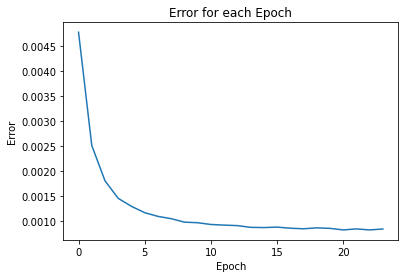

In [110]:
plt.plot(errors)
plt.title('Error for each Epoch')
plt.ylabel('Error')
plt.xlabel('Epoch')
plt.show()

It looks like the error is very low, with possible diminishing returns after epoch 15 or so. It also ran pretty fast, showing its efficiency.
### Recommend to Mock User
Let's create a mock user so we can recommend products to it based on the RBM. We will begin by picking 143 for c2's reviews, before making an array of their values. We will then pass it in the input and reconstruct the data with a recommendation score.

In [101]:
# select a user: mock_user_id = 143
mock_user_id = 143

In [102]:
# Selecting the input user
inputUser = trX[mock_user_id-1].reshape(1, -1)
inputUser[0:5]

array([[0., 0., 0., ..., 0., 0., 0.]])

In [103]:
# Feeding in the user and reconstructing the input. use sigmoid
hh0 = tf.nn.sigmoid(tf.matmul(v0, W) + hb)
vv1 = tf.nn.sigmoid(tf.matmul(hh0, tf.transpose(W)) + vb)
feed = sess.run(hh0, feed_dict={ v0: inputUser, W: prv_w, hb: prv_hb})
rec = sess.run(vv1, feed_dict={ hh0: feed, W: prv_w, vb: prv_vb})

In [109]:
scored_product_df_mock = cleaned.drop_duplicates(subset=['ProductId']) # create df to assign recommendation score
# create column and store RecommendationScore
scored_product_df_mock = scored_product_df_mock.assign(RecommendationScore = rec[0])
# sort values based on RecommendationScore
scored_product_df_mock[['ProductId','RecommendationScore','Summary','Text']].sort_values(["RecommendationScore"], ascending=False).head(20)

,ProductId,RecommendationScore,Summary,Text
13047,B001FA1K5S,0.018063,Better and Cheaper Than US Version,"We got Mexican Nesquik because it was cheaper,..."
13046,B002FKG5MA,0.016052,great coffee,There is nothing better then good coffee at a ...
13033,B0011XKHY4,0.015589,airplane cookies! YUM!!,These cookies are so good. I love them. I firs...
3804,B000X2CWTM,0.013651,Real Licorice,I received a box of this for Christmas. It is ...
22788,B00800CDCA,0.012244,Spices for canning,Great product and price if you need large quan...
153,B002HQAXUW,0.012105,Rip off Price,These singles sell for $2.50 - $3.36 at the st...
12541,B005J7I8FS,0.011919,Delicious wine!! Yummy!,"Great with BBQ, we have discovered and focusin..."
13815,B0051SZD0S,0.011843,LA VICTORIA GREEN TACO SAUCE,"THIS IS ""GREEN GOLD""; I DISCOVERED IT WHILE LI..."
13767,B001M0ALS8,0.011754,Gordolobo Tea....,This tea is very tasty. I drink one cup of hot...
12890,B004U7QZ4Y,0.011752,Smooth & Awakening!,Tazo Awake Full Leaf Tea is the best black tea...


We are also going to make a df with only user 151's info so we can create a df with the score

In [105]:
food_df_mock = cleaned[cleaned['UserID'] == 151]
food_df_mock.head()

,ProductId,ProfileName,Score,Summary,Text,HelpfulnessNumerator,HelpfulnessDenominator,Polarity_Rating,UserID
151,B00374XSVY,Chris,5,Awesome stuff,Works with chicken fish beef or pork. Fast eas...,0,0,Positive,151
637,B000G6RYNE,Chris,4,kettle chips,"This kettle chips taste ""Good , Crispy & Crunc...",0,0,Positive,151
729,B008BEGP9W,Chris,4,A Surprising Find,I really like the pineapple shortcakes sold he...,0,0,Positive,151
1006,B002XG21MO,Chris,5,A great price!,These are just like the animal crackers we eat...,0,0,Positive,151
3142,B000FDKQCY,Chris,5,Good to use the bread machine again,This product is as good as any that I have eve...,0,0,Positive,151


In [106]:
#Merging scored_product_df_mock with food_df_mock by ProductID
merged_df_mock = scored_product_df_mock.merge(food_df_mock, on='ProductId', how='outer')

In [115]:
merged_df_mock.head()

,ProductId,ProfileName_x,Score_x,Summary_x,Text_x,HelpfulnessNumerator_x,HelpfulnessDenominator_x,Polarity_Rating_x,UserID_x,RecommendationScore,ProfileName_y,Score_y,Summary_y,Text_y,HelpfulnessNumerator_y,HelpfulnessDenominator_y,Polarity_Rating_y,UserID_y
0,B001E4KFG0,delmartian,5,Good Quality Dog Food,I have bought several of the Vitality canned d...,1,1,Positive,1,0.008326,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,B00813GRG4,dll pa,1,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...,0,0,Negative,2,0.005532,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,B000LQOCH0,"Natalia Corres ""Natalia Corres""",4,"""Delight"" says it all",This is a confection that has been around a fe...,1,1,Positive,3,0.008647,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,B000UA0QIQ,Karl,2,Cough Medicine,If you are looking for the secret ingredient i...,3,3,Negative,4,0.007829,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,B006K2ZZ7K,"Michael D. Bigham ""M. Wassir""",5,Great taffy,Great taffy at a great price. There was a wid...,0,0,Positive,5,0.008145,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Finally, this last line will show the top 5 products it recommends to user c2 based on highest recommendation score. It will also show the summary and review so we can have an idea of what the product actually is.

In [128]:
merged_df_mock[['ProductId','RecommendationScore','Summary_x','Text_x','UserID_x']].sort_values(["RecommendationScore"], ascending=False).head(5)

,ProductId,RecommendationScore,Summary_x,Text_x,UserID_x
1881,B001FA1K5S,0.018063,Better and Cheaper Than US Version,"We got Mexican Nesquik because it was cheaper,...",11243
1880,B002FKG5MA,0.016052,great coffee,There is nothing better then good coffee at a ...,11242
1879,B0011XKHY4,0.015589,airplane cookies! YUM!!,These cookies are so good. I love them. I firs...,11230
595,B000X2CWTM,0.013651,Real Licorice,I received a box of this for Christmas. It is ...,3585
2908,B00800CDCA,0.012244,Spices for canning,Great product and price if you need large quan...,18861


Once again, let's make a function that takes index as input and returns recommendation for that userID.

In [129]:
def give_recommendations(userID, recs = 5):
    mock_user_id = userID
    inputUser = trX[mock_user_id-1].reshape(1, -1)
    # Feeding in the user and reconstructing the input. use sigmoid
    hh0 = tf.nn.sigmoid(tf.matmul(v0, W) + hb)
    vv1 = tf.nn.sigmoid(tf.matmul(hh0, tf.transpose(W)) + vb)
    feed = sess.run(hh0, feed_dict={ v0: inputUser, W: prv_w, hb: prv_hb})
    rec = sess.run(vv1, feed_dict={ hh0: feed, W: prv_w, vb: prv_vb})
    scored_product_df_mock = cleaned.drop_duplicates(subset=['ProductId']) # create df to assign recommendation score
    # create column and store RecommendationScore
    scored_product_df_mock = scored_product_df_mock.assign(RecommendationScore = rec[0])
    food_df_mock = cleaned[cleaned['UserID'] == userID]
    merged_df_mock = scored_product_df_mock.merge(food_df_mock, on='ProductId', how='outer')
    rec_df = merged_df_mock[['ProductId','RecommendationScore','Summary_x','Text_x','UserID_x']].sort_values(["RecommendationScore"], ascending=False).head(recs)
    print(f'Top {recs} Product Recommendations for UserID: {userID}:')
    return rec_df

In [130]:
give_recommendations(24,8)

Top 8 Product Recommendations for UserID: 24:


,ProductId,RecommendationScore,Summary_x,Text_x,UserID_x
958,B003JMH0FY,0.623005,Heavenly!,This is the best quality Chamomile tea I have ...,5716
2447,B001TM3XKW,0.015070,Weruva Bed and Breakfast Canned Dog Food,Although this is very expensive canned dog foo...,15459
2524,B003SC0Q4C,0.012133,Very good stuff,"Mmm, The other two reviewers seem to be lacki...",15923
587,B005TAGBVS,0.008702,Really good product!,These bites are 'just enough' for a snack. The...,3514
1320,B0028621BU,0.007732,Overpriced - not 18lb bags!,"When I bought this food, I saw the image and p...",8038
1748,B0005YLOH4,0.005585,"Bananas, for baby... or for space flight",Anyone searching for stage 3 of gestational ba...,10756
2024,B00374XTQI,0.004994,my own lil store,Received package and was just as I wanted plus...,12321
1610,B0040U9KS4,0.004975,Love this gum.,Very good gum - flavor doesn't last a long tim...,9861



## Conclusions
The DL tools at our disposal is constantly growing more powerful and complex, but that does not necessarily mean more computational power in some cases as they can become more efficient as well. For comparison, the simple RNN with LSTM took over an hour to fit with only 8 epochs, while the RBM geared for efficiency did 24 epochs in under 10 minutes. They both had very low error, and were possibly overfit.
<br><br>
If I were to do this over again, I would probably make the score of 3 positive rather than negative, or keep it neutral and used softmax with 3 dense neurons or tanh. Better yet, I should of tuned my hyperparameters with hparams or tensorboard rather than encoding in Kobe Bryant easter eggs. 
<br><br>
Overall, I am happy with how well the models performed, but there is definitely room for improvements.